# Integer percentages in Russian elections 2000--2018

Literature:

1. Kobak, D., Shpilkin, S., & Pshenichnikov, M. S. (2016). [Integer percentages as electoral falsification fingerprints](https://projecteuclid.org/euclid.aoas/1458909907). *The Annals of Applied Statistics*, 10(1), 54--73.
2. Kobak, D., Shpilkin, S., & Pshenichnikov, M. S. (2016). [Statistical fingerprints of electoral fraud?](http://onlinelibrary.wiley.com/doi/10.1111/j.1740-9713.2016.00936.x/full). *Significance*, 13(4), 20--23.
2. Kobak, D., Shpilkin, S., & Pshenichnikov, M. S. (2018). [Putin's peaks: Russian election data revisited](https://rss.onlinelibrary.wiley.com/doi/10.1111/j.1740-9713.2018.01141.x). *Significance*, 15(3), 8--9

This notebook reproduces the analysis from Ref. 3.

## Prepare the notebook and load the data

In [1]:
# Load libraries and set up notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
from zipfile import ZipFile
import pickle
import time

import matplotlib as mpl
mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

In [2]:
# Load data for a given year

def loaddata(year):
    zip_file = ZipFile('electionsData.zip')
    
    table = pd.read_csv(zip_file.open('{}.txt'.format(year)), sep='\t')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    voters = np.squeeze(table[col].values)
    
    colFilter = ['бюллетеней, выданных']                # should select 3 columns
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    given = np.sum(table[col].values, axis=1)

    colFilter = ['действительных', 'недействительных']  # should select 2 columns
    excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
    col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                           all([f not in col for f in excludeFilter])]
    received = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks    = table['tik'].values
    uiks    = table['uik'].values
    
    return (voters, given, received, leader, regions, tiks, uiks)

## Histograms

<IPython.core.display.Javascript object>


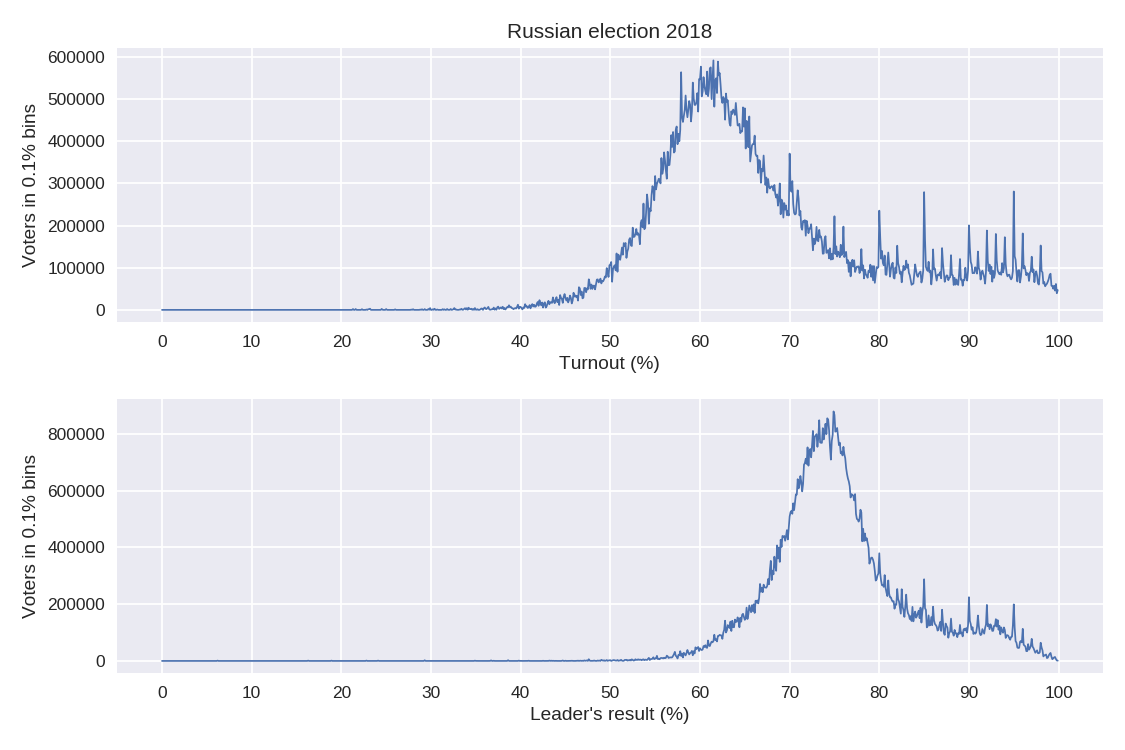

In [3]:
# Histograms for one particular year

year     = 2018        # Election year
binwidth = 0.1         # Bin width (in percentage points)
addNoise = False       # If add U(-0.5,0.5) noise to the nominators (to remove division artifacts)
weights  = 'voters'    # Weights: can be 'off'     (counts polling stations), 
                       #                 'voters'  (counts registered voters),
                       #                 'given'   (counts given ballots)
                       #                 'leader'  (counts ballots for the leader)
minSize  = 0           # Exclude polling stations with number of voters less than minSize

# Settings used in our papers:
# * AOAS-2016:         binwidth=0.1,  addNoise=False, weights='voters', minSize = 0
# * Significance-2016: binwidth=0.25, addNoise=True,  weights='off'     minSize = 0
# * Significance-2018: binwidth=0.1,  addNoise=True,  weights='off'     minSize = 0

######################################################################################

voters, given, received, leader = loaddata(year)[:4]

ind = (received > 0) & (given < voters) & (voters >= minSize)
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'

sns.set()
plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{} in {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,10))
plt.title('Russian election {}'.format(year))

plt.subplot(212)
plt.plot(centers, h2, linewidth=1)
plt.xlabel("Leader's result (%)")
plt.ylabel('{} in {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,10))

plt.tight_layout()

<IPython.core.display.Javascript object>


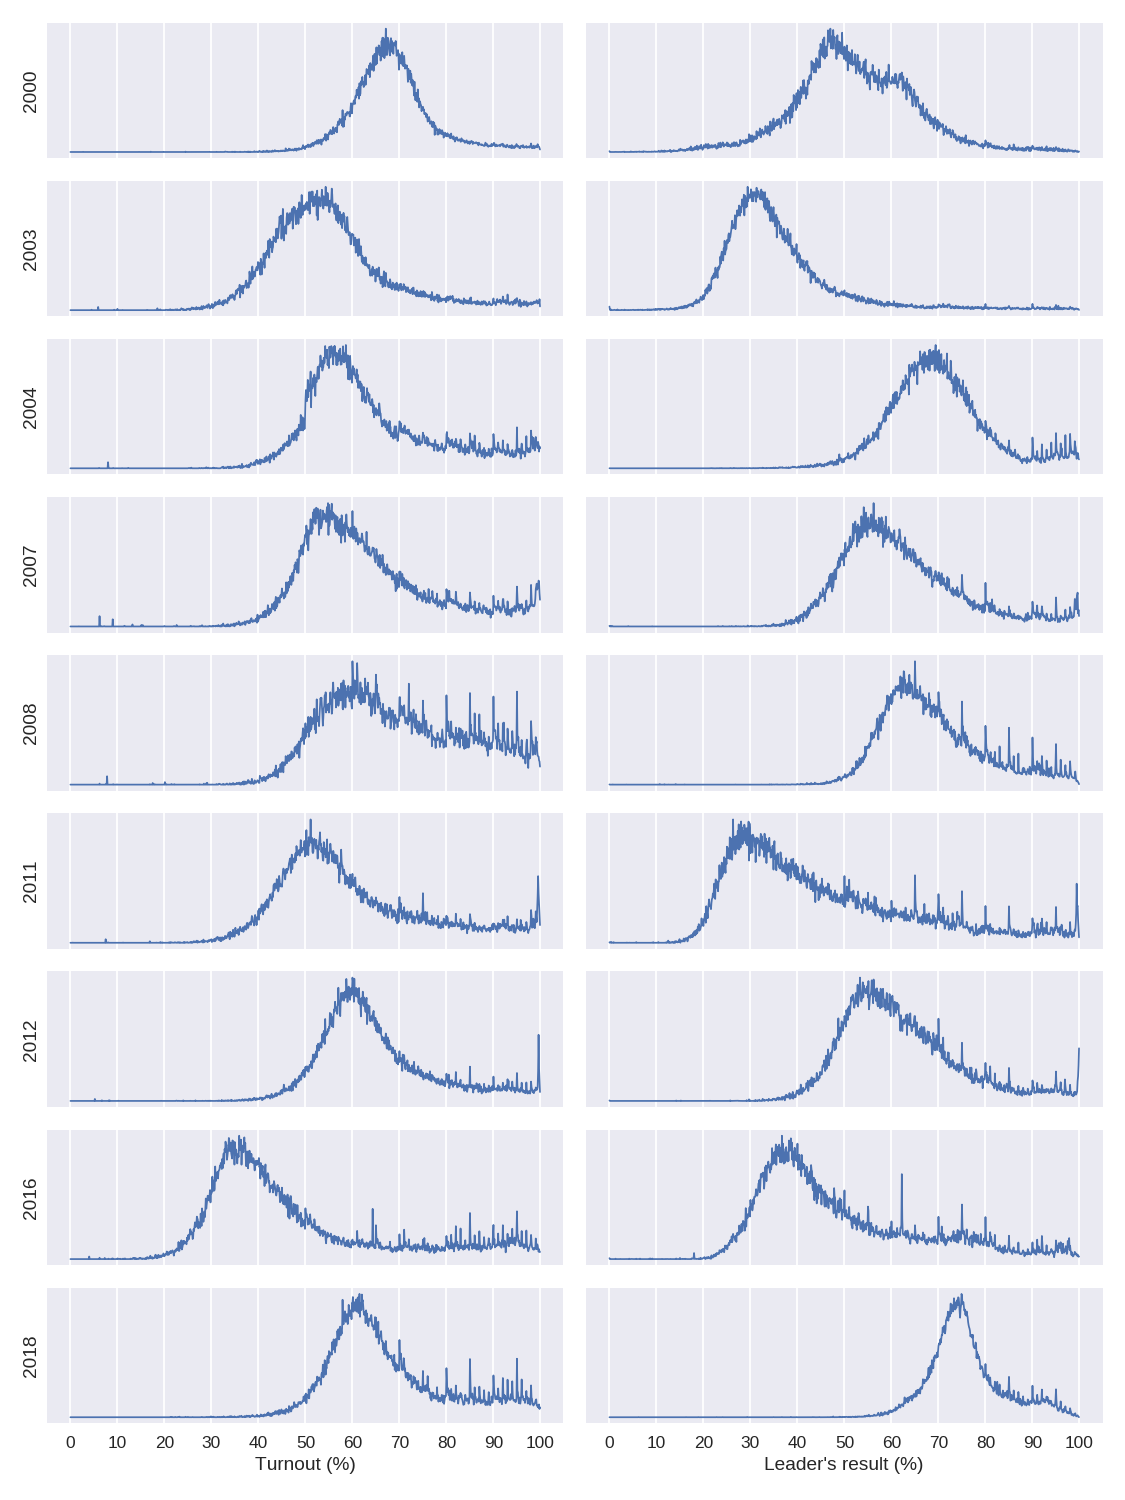

In [13]:
# Histograms for all years

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018]

binwidth = 0.1        # See above for parameters explanation
addNoise = False  
weights  = 'voters'
minSize  = 0

######################################################################################

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'

sns.set()
plt.figure(figsize=(9,12))

for i,year in enumerate(years):
    voters, given, received, leader = loaddata(year)[:4]

    ind = (received > 0) & (given < voters) & (voters >= minSize)
    np.random.seed(42)
    noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

    w = None
    if weights == 'voters': w = voters[ind]
    if weights == 'given':  w = given[ind]
    if weights == 'leader': w = leader[ind]
    h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
    h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

    plt.subplot(len(years), 2, i*2+1)
    plt.plot(centers, h1, linewidth=1)
    plt.xticks(np.arange(0,101,10))
    if i==len(years)-1:
        plt.xlabel("Turnout (%)")
    else:
        plt.gca().set_xticklabels([])
    plt.ylabel(year)
    plt.yticks([])

    plt.subplot(len(years), 2, i*2+2)
    plt.plot(centers, h2, linewidth=1)
    plt.xticks(np.arange(0,101,10))
    plt.yticks([])
    if i==len(years)-1:
        plt.xlabel("Leader's result (%)")
    else:
        plt.gca().set_xticklabels([])

plt.tight_layout()

Regions: Кемеровская, Краснодарский, Башкортостан, Дагестан, Татарстан
Fraction of voters in these regions: 12.5%
Voters in these regions: 13.7 mln


<IPython.core.display.Javascript object>


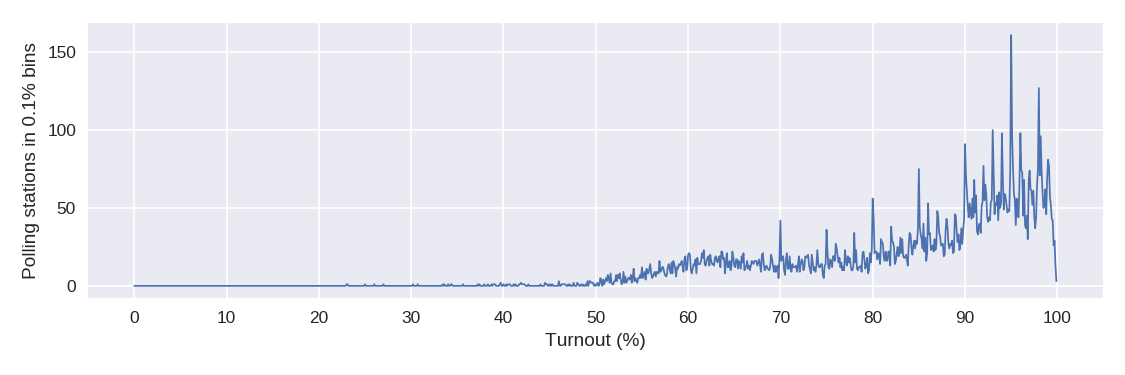

In [5]:
# Most preposterous regions in 2018

year     = 2018
binwidth = 0.1        # See above for parameters explanation
addNoise = True  
weights  = 'off'
minSize  = 0

regs = ['Кемеровская', 'Краснодарский', 'Башкортостан', 'Дагестан', 'Татарстан']

voters, given, received, leader, regions = loaddata(year)[:5]

mask = [any([e in r for e in regs]) for r in regions]

print('Regions:', ', '.join(regs))
print('Fraction of voters in these regions: {:2.1f}%'.format(100*np.sum(voters[mask])/np.sum(voters)))
print('Voters in these regions: {:2.1f} mln'.format(np.sum(voters[mask])/1e+6))

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

ind = (received > 0) & (given < voters) & (voters >= minSize) & mask

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'
    
sns.set()
plt.figure(figsize=(9,3))
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{} in {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101, 10))
plt.gca().xaxis.grid(True)

plt.tight_layout()

## Figures for the Significance-2018 paper

<IPython.core.display.Javascript object>


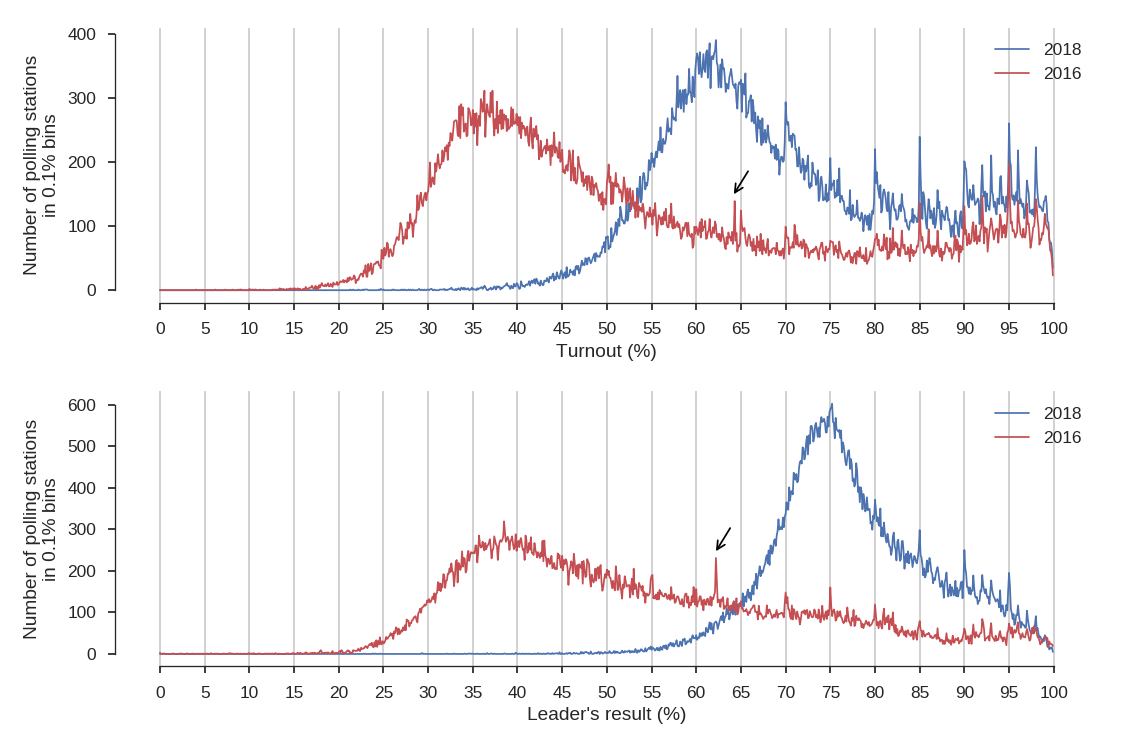

In [6]:
# Histograms 2016 and 2018

voters2016, given2016, received2016, leader2016 = loaddata(2016)[:4]
voters2018, given2018, received2018, leader2018 = loaddata(2018)[:4]

binwidth = 0.1
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

ind2016 = (received2016 > 0) & (given2016 < voters2016)
ind2018 = (received2018 > 0) & (given2018 < voters2018)

np.random.seed(42)
noise2018 = np.random.rand(given2018.size) - .5
noise2016 = np.random.rand(given2016.size) - .5

sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
plt.figure(figsize=(9,6))
plt.subplot(211)
h = np.histogram(100 * (given2018+noise2018)[ind2018]/voters2018[ind2018], bins=edges)[0]
plt.plot(centers, h, linewidth=1)
next(plt.gca()._get_lines.prop_cycler)
h = np.histogram(100 * (given2016+noise2016)[ind2016]/voters2016[ind2016], bins=edges)[0]
plt.plot(centers, h, linewidth=1)
plt.annotate("", xy=(64, 145), xytext=(66, 190), arrowprops=dict(arrowstyle="->",facecolor='black',linewidth=1))

plt.legend([2018,2016])
plt.xlabel("Turnout (%)")
plt.ylabel('Number of polling stations\nin 0.1% bins')
plt.xticks(np.arange(0,101, 5))
plt.gca().xaxis.grid(True)

plt.subplot(212)
h = np.histogram(100 * (leader2018+noise2018)[ind2018]/received2018[ind2018], bins=edges)[0]
plt.plot(centers, h, linewidth=1)
next(plt.gca()._get_lines.prop_cycler)
h = np.histogram(100 * (leader2016+noise2016)[ind2016]/received2016[ind2016], bins=edges)[0]
plt.plot(centers, h, linewidth=1)
plt.annotate("", xy=(62, 240), xytext=(64, 310), arrowprops=dict(arrowstyle="->",facecolor='black',linewidth=1))

plt.legend([2018,2016])
plt.xlabel("Leader's result (%)")
plt.ylabel('Number of polling stations\nin 0.1% bins')
plt.xticks(np.arange(0,101, 5))
plt.gca().xaxis.grid(True)

sns.despine(trim=True)
plt.tight_layout()

plt.savefig('significance-aftermath-peaks.pdf')

In [75]:
# Monte Carlo simulations

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42, 
            binwidth = .1, period = 1):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2) | 
                                (np.abs(p2 - np.round(p2/period)*period)) <= binwidth/2)])
        integer[1,i] = np.sum(w[ np.abs(p1 - np.round(p1/period)*period)) <= binwidth/2])
        integer[2,i] = np.sum(w[ np.abs(p2 - np.round(p2/period)*period)) <= binwidth/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/period)*period)) <= binwidth/2) | 
                                        (np.abs(p2 - np.round(p2/period)*period)) <= binwidth/2)).astype(int), axis=1)
        integer_mc[1,i,:] = np.sum(w *  (np.abs(p1 - np.round(p1/period)*period)) <= binwidth/2).astype(int), axis=1)
        integer_mc[2,i,:] = np.sum(w *  (np.abs(p2 - np.round(p2/period)*period)) <= binwidth/2).astype(int), axis=1)
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

In [77]:
years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
anomalies = np.zeros((years.size, 3, 4))
stds  = np.zeros((years.size, 3, 4))
prctls = np.zeros((years.size, 3, 4))

for i,y in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(y)
    a = anomaly(voters, given, received, leader)
    anomalies[i,:,:] = a[0]
    stds[i,:,:]      = a[1]
    prctls[i,:,:]    = a[2]
    
with open('montecarlo.pickle', 'wb') as f:
    pickle.dump([anomalies, stds, prctls], f)

..................................................................................... 1m 29s
........................................................................................ 1m 38s
...................................................................................... 1m 41s
...................................................................................... 1m 43s
....................................................................................... 1m 46s
....................................................................................... 1m 34s
........................................................................................ 1m 35s
........................................................................................... 1m 36s
............................................................................................ 1m 41s


<IPython.core.display.Javascript object>


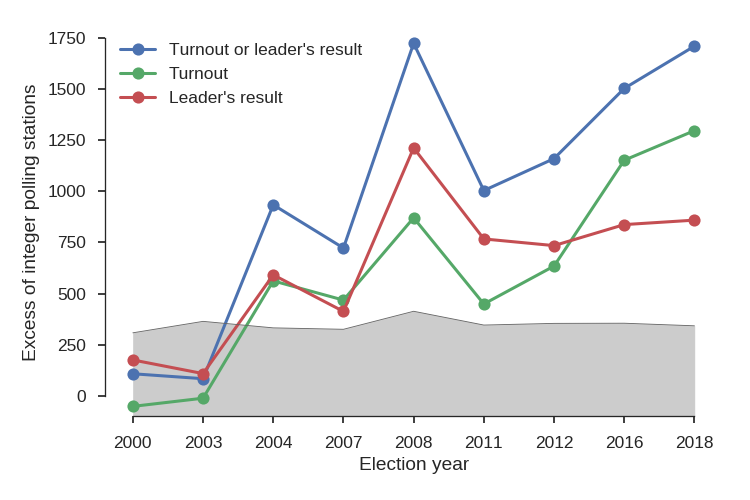

In [7]:
with open('montecarlo.pickle', 'rb') as f:
    [anomalies, stds, prctls] = pickle.load(f)
    years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
    
sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
plt.figure(figsize=(6,4))
plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
plt.plot(prctls[:,0,0], '-', color=[.4,.4,.4], linewidth=.5)
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or leader's result", "Turnout", "Leader's result"))
plt.ylabel('Excess of integer polling stations')
plt.xlabel('Election year')
plt.ylim([-100, 1800])
plt.xticks(np.arange(years.size), years)
sns.despine(trim=True)
plt.tight_layout()

plt.savefig('significance-aftermath-anomalies.pdf')

# Additional anomalies

<IPython.core.display.Javascript object>


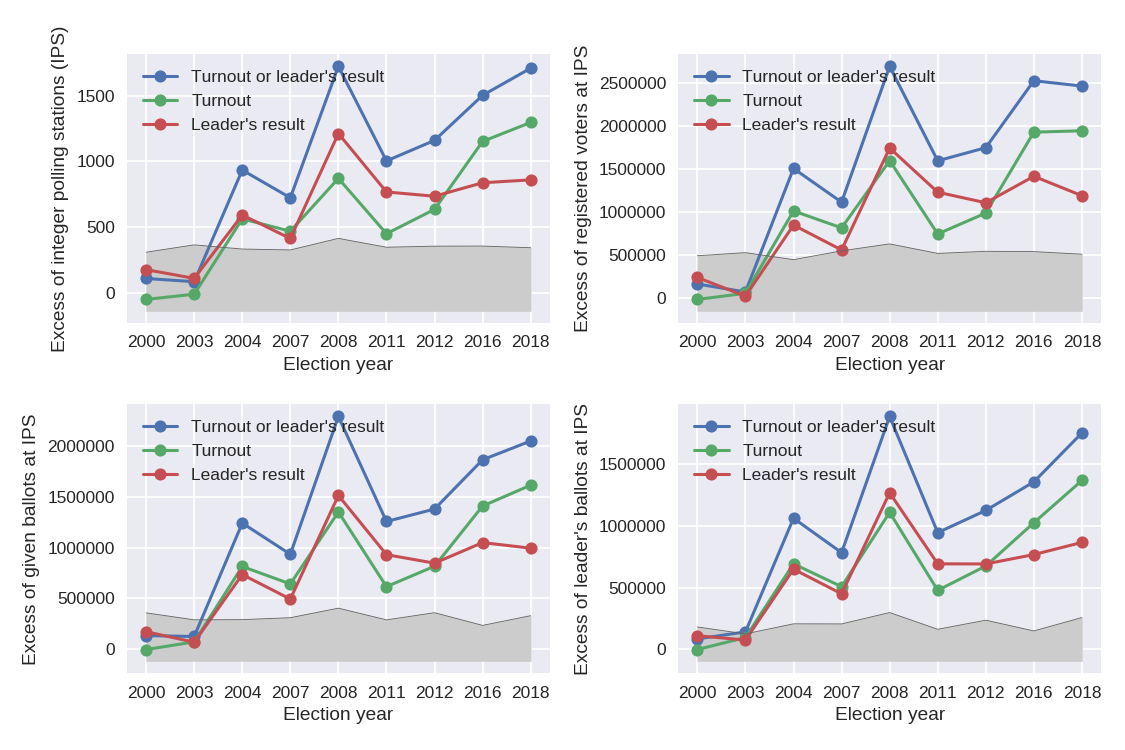

In [4]:
with open('montecarlo.pickle', 'rb') as f:
    [anomalies, stds, prctls] = pickle.load(f)
    years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
    
sns.set()
plt.figure(figsize=(9,6))
titles = ['Excess of integer polling stations (IPS)', 'Excess of registered voters at IPS',
          'Excess of given ballots at IPS', "Excess of leader's ballots at IPS"]
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(anomalies[:,0,i], '-o')
    plt.plot(anomalies[:,2,i], '-o')
    plt.plot(anomalies[:,1,i], '-o')
    plt.plot(prctls[:,0,i], '-', color=[.4,.4,.4], linewidth=.5)
    plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,i], color=[.8,.8,.8])
    plt.legend(("Turnout or leader's result", "Turnout", "Leader's result"), loc='upper left')
    plt.ylabel(titles[i])
    plt.xlabel('Election year')
    plt.xticks(np.arange(years.size), years)
plt.tight_layout()

## 2D Histograms

<IPython.core.display.Javascript object>


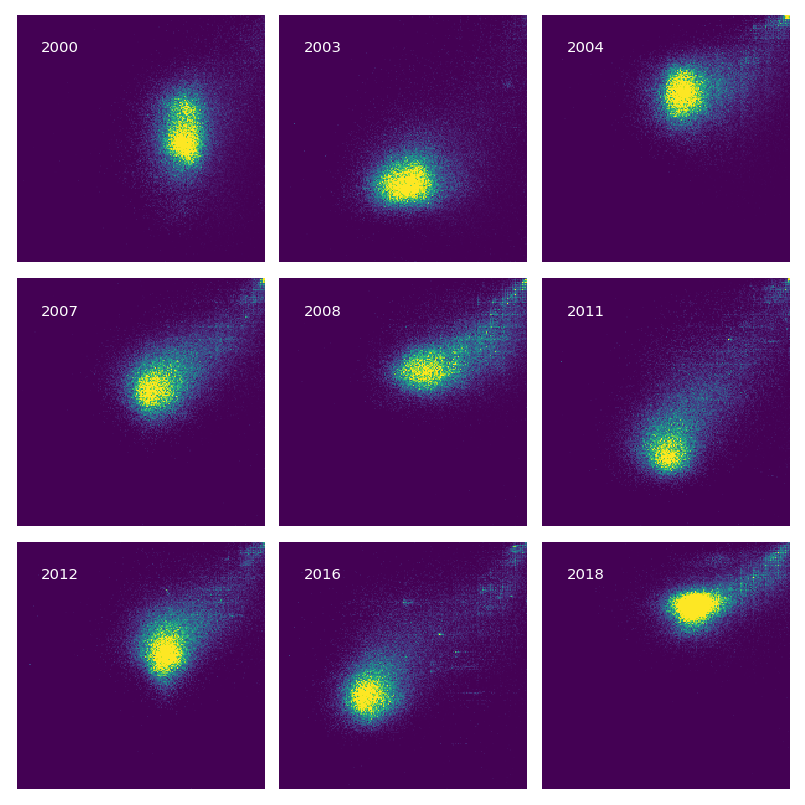

In [38]:
# 2D histograms for all years

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018]
binwidth = 0.5
minSize = 0

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(9,9))
for i,y in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(y)

    plt.subplot(3, 3, i+1)
    ind = (received > 0) & (given < voters) & (voters >= minSize) & np.array(['Зарубеж' not in s and 'за пределами' not in s for s in regions])
    h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], 
                       bins=edges, weights = voters[ind])[0]
    plt.imshow(h.T, vmin=0, vmax=50000, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('viridis'), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.text(10,85,y, color='w')

plt.tight_layout()

<IPython.core.display.Javascript object>


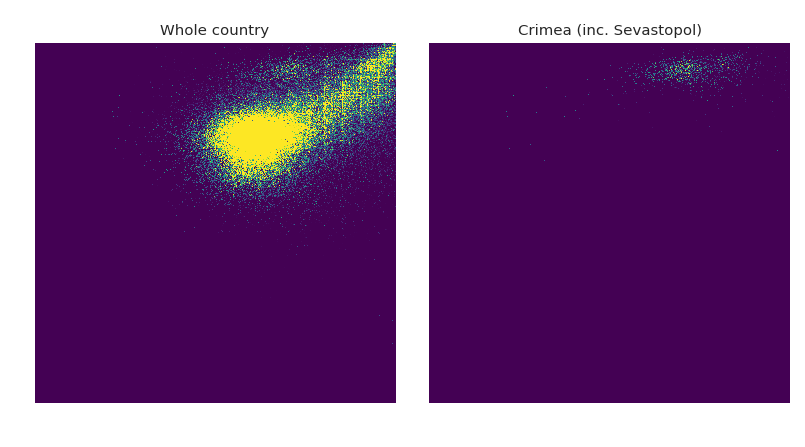

In [42]:
# 2D histogram for 2018 and bimodality caused by Crimea 

binwidth = 0.25
voters, given, received, leader, regions, tiks = loaddata(2018)

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(9,5))
plt.subplot(121)
plt.title('Whole country')
ind = (received > 0) & (given < voters) & (voters >= minSize) & np.array(['Зарубеж' not in s and 'за пределами' not in s for s in regions])
h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], 
                   bins=edges, weights = voters[ind])[0]
plt.imshow(h.T, vmin=0, vmax=5000, origin='lower', extent=[0,100,0,100], cmap=plt.get_cmap('viridis'))
plt.xlabel("Turnout (%)")
plt.ylabel("Putin's result (%)")
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(122)
plt.title('Crimea (inc. Sevastopol)')
ind = (received > 0) & (given < voters) & (voters >= minSize) & ((regions=='Республика Крым') | (regions=='город Севастополь'))

h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], 
                   bins=edges, weights = voters[ind])[0]
plt.imshow(h.T, vmin=0, vmax=5000, origin='lower', extent=[0,100,0,100], cmap=plt.get_cmap('viridis'))
plt.xlabel("Turnout (%)")
plt.ylabel("Putin's result (%)")
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.tight_layout()

## Regions

<IPython.core.display.Javascript object>


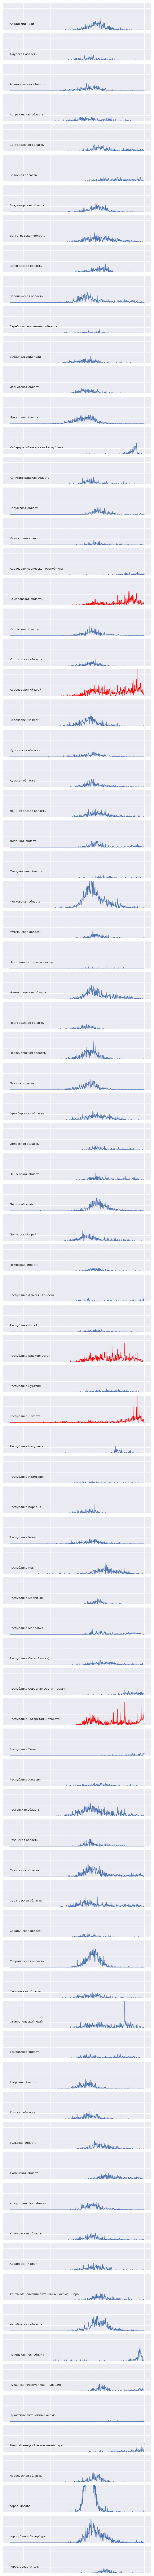

In [47]:
# Turnout histograms for every region in a given year

year = 2018
binwidth = 0.1         # See above for parameters explanation
addNoise = False  
weights  = 'voters'
minSize  = 0

cutoff = 200000        # Regions with anomaly above cutoff are plotted in red
                       # Here anomaly = sum over integer percentages - sum over half-integer percentages

######################################################################################

voters, given, received, leader, regions, tiks = loaddata(year)

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

sns.set()
plt.figure(figsize=(9,150))

regs = [r for r in np.unique(regions) if r[0]!='9'] # Excluding territories outside of Russia
for i,r in enumerate(regs):
    plt.subplot(len(regs), 1, i+1)

    ind = (received > 0) & (given < voters) & (voters >= minSize) & (regions==r)
    np.random.seed(42)
    noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5
    w = None
    if weights == 'voters':  w = voters[ind]
    if weights == 'ballots': w = given[ind]
    h = np.histogram(100 * (given[ind]+noise)/voters[ind], bins=edges, weights = w)[0]
    
    ind1 = np.abs(centers - np.floor(centers)) < 1e-5
    ind2 = np.abs(centers - 0.5 - np.floor(centers)) < 1e-5
    anomaly = np.sum(h[ind1]) - np.sum(h[ind2])
    
    if anomaly > cutoff:
        plt.plot(centers, h, linewidth=1, color = 'r')
    else:
        plt.plot(centers, h, linewidth=1)
    plt.xticks(np.arange(0,101, 10))
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.ylim([0, 50000])
    plt.text(0,10000,r)
    
plt.tight_layout()